## Question 1: Propensity score matching

In this exercise, you will apply [propensity score matching](http://www.stewartschultz.com/statistics/books/Design%20of%20observational%20studies.pdf), which we discussed in lecture 5 ("Observational studies"), in order to draw conclusions from an observational study.

We will work with a by-now classic dataset from Robert LaLonde's study "[Evaluating the Econometric Evaluations of Training Programs](http://people.hbs.edu/nashraf/LaLonde_1986.pdf)" (1986).
The study investigated the effect of a job training program ("National Supported Work Demonstration") on the real earnings of an individual, a couple of years after completion of the program.
Your task is to determine the effectiveness of the "treatment" represented by the job training program.

#### Dataset description

- `treat`: 1 if the subject participated in the job training program, 0 otherwise
- `age`: the subject's age
- `educ`: years of education
- `race`: categorical variable with three possible values: Black, Hispanic, or White
- `married`: 1 if the subject was married at the time of the training program, 0 otherwise
- `nodegree`: 1 if the subject has earned no school degree, 0 otherwise
- `re74`: real earnings in 1974 (pre-treatment)
- `re75`: real earnings in 1975 (pre-treatment)
- `re78`: real earnings in 1978 (outcome)

If you want to brush up your knowledge on propensity scores and observational studies, we highly recommend Rosenbaum's excellent book on the ["Design of Observational Studies"](http://www.stewartschultz.com/statistics/books/Design%20of%20observational%20studies.pdf). Even just reading the first chapter (18 pages) will help you a lot.

In [167]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from pandas.plotting import scatter_matrix
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
import seaborn as sns
import itertools
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from matplotlib import cm
from sklearn.datasets import make_classification
from sklearn.ensemble import ExtraTreesClassifier
%matplotlib inline
from sklearn import linear_model



#### 1. A naive analysis

Compare the distribution of the outcome variable (`re78`) between the two groups, using plots and numbers.
To summarize and compare the distributions, you may use the techniques we discussed in lectures 4 ("Read the stats carefully") and 6 ("Data visualization").

What might a naive "researcher" conclude from this superficial analysis?

In [274]:
NSWD = pd.read_csv('lalonde.csv', index_col=0)
NSWD.head()

,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78
id,,,,,,,,,,
NSW1,1,37,11,1,0,1,1,0.0,0.0,9930.0460
NSW2,1,22,9,0,1,0,1,0.0,0.0,3595.8940
NSW3,1,30,12,1,0,0,0,0.0,0.0,24909.4500
NSW4,1,27,11,1,0,0,1,0.0,0.0,7506.1460
NSW5,1,33,8,1,0,0,1,0.0,0.0,289.7899


#### Naive analysis

The following information about the data frame and its features was found online:

The variables from left to right are: treatment indicator (1 if treated, 0 if not treated), age, education, Black (1 if black, 0 otherwise), Hispanic (1 if Hispanic, 0 otherwise), married (1 if married, 0 otherwise), nodegree (1 if no degree, 0 otherwise), RE74 (earnings in 1974), RE75 (earnings in 1975), and RE78 (earnings in 1978).


We create subframes and then take a closer look at the data by comparing the key statistics for both groups (treatment vs control) and plotting some graphs.

In [306]:
# We create two data frames, one for treated and one for non-treated
treat = NSWD[NSWD['treat']==1]
control = NSWD[NSWD['treat']==0]
# For later use we store the size of both subsets
control_total = len(control)
treat_total = len(treat)
# We store the re78 columns of both frames
control_re78 = control[['re78']]
treat_re78 = treat[['re78']]

# We also create a frame that only contains treatment and re78
NSWD_re78 = NSWD[['treat', 're78']]

NSWD_re78.groupby('treat').describe()

re78                                                                \
       count         mean          std  min       25%       50%        75%   
treat                                                                        
0      429.0  6984.169742  7294.161791  0.0  220.1813  4975.505  11688.820   
1      185.0  6349.143530  7867.402218  0.0  485.2298  4232.309   9642.999   

                 
            max  
treat            
0      25564.67  
1      60307.93

As we can see the treatment group is more than twice as big. 

The mean, median and third quartile are all lower for the treatment group, while the maximum value is significantly higher for the treatment group.

A boxplot visualises this better and also shows that there are number of 'outliers' for the treatment group. The violinplot gives more detail by showing us that the treatment group is broader in the region 5000-15000 USD, but then thins out relative to the control group.

In [276]:
NSWD_re78.groupby('treat').describe()

re78                                                                \
       count         mean          std  min       25%       50%        75%   
treat                                                                        
0      429.0  6984.169742  7294.161791  0.0  220.1813  4975.505  11688.820   
1      185.0  6349.143530  7867.402218  0.0  485.2298  4232.309   9642.999   

                 
            max  
treat            
0      25564.67  
1      60307.93

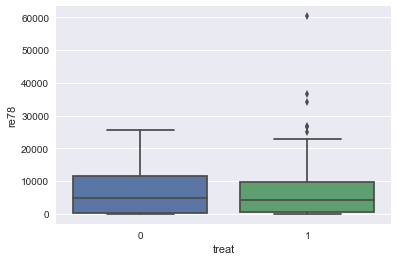

In [277]:
sns.boxplot(x="treat", y="re78", data=NSWD);

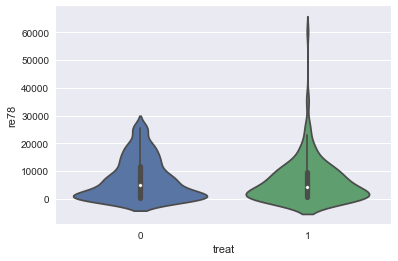

In [278]:
sns.violinplot(x="treat", y="re78", data=NSWD);

Contrasting the boxplots (we chose bins of widths USD 2500) reconfirms the expression from the above plots.

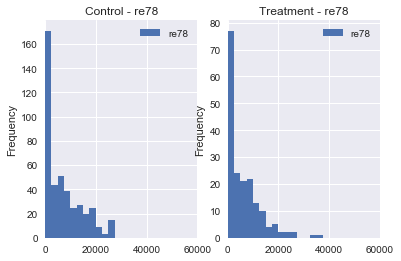

In [280]:
bin_values = np.arange(start=0, stop=62500, step=2500)

fig, axes = plt.subplots(1, 2)
control_re78.plot.hist(ax=axes[0], xlim = (0,60000), title='Control - re78', bins=bin_values)
treat_re78.plot.hist(ax=axes[1], xlim = (0,60000), title='Treatment - re78', bins=bin_values)



#### 2. A closer look at the data

You're not naive, of course (and even if you are, you've learned certain things in ADA), so you aren't content with a superficial analysis such as the above.
You're aware of the dangers of observational studies, so you take a closer look at the data before jumping to conclusions.

For each feature in the dataset, compare its distribution in the treated group with its distribution in the control group, using plots and numbers.
As above, you may use the techniques we discussed in class for summarizing and comparing the distributions.

What do you observe?
Describe what your observations mean for the conclusions drawn by the naive "researcher" from his superficial analysis.



We need to plot the bar plots and numbers for each feature like age etc. and compare. 

In [281]:
NSWD.head()

,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78
id,,,,,,,,,,
NSW1,1,37,11,1,0,1,1,0.0,0.0,9930.0460
NSW2,1,22,9,0,1,0,1,0.0,0.0,3595.8940
NSW3,1,30,12,1,0,0,0,0.0,0.0,24909.4500
NSW4,1,27,11,1,0,0,1,0.0,0.0,7506.1460
NSW5,1,33,8,1,0,0,1,0.0,0.0,289.7899


We plot the relative frequencies of different features. Certain properties of the graphs have been tweaked (e.g. xlim and ylim) to generate useful display.

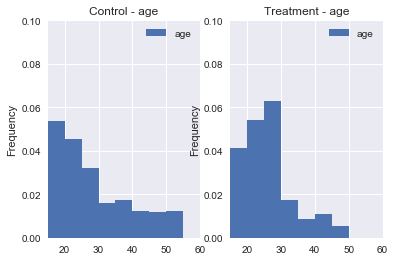

In [282]:
control_age = control[['age']]
treat_age= treat[['age']]


bin_values_age = np.arange(start=15, stop=60, step=5) # age ranges from 16 to 55

fig, axes = plt.subplots(1, 2)
control_age.plot.hist(ax=axes[0], xlim = (15,60), ylim = (0,0.1), normed=True , title='Control - age', bins=bin_values_age)
treat_age.plot.hist(ax=axes[1], xlim = (15,60), ylim = (0,0.1), normed=True, title='Treatment - age', bins=bin_values_age)

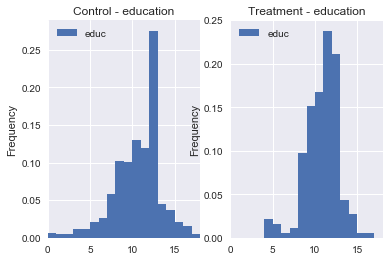

In [283]:
control_educ = control[['educ']]
treat_educ= treat[['educ']]

bin_values_educ = np.arange(start=0, stop=20, step=1) # education ranges from 0 to 18

fig, axes = plt.subplots(1, 2)
control_educ.plot.hist(ax=axes[0], xlim = (0,18), normed=True , title='Control - education', bins=bin_values_educ)
treat_educ.plot.hist(ax=axes[1], xlim = (0,18), normed=True, title='Treatment - education', bins=bin_values_educ)

In [284]:
control_total_black  = control['black'].sum()
treat_total_black  = treat['black'].sum()
control_total_hispan = control['hispan'].sum()
treat_total_hispan  = treat['hispan'].sum()
control_total_white = control_total - control_total_black - control_total_hispan
treat_total_white  = treat_total - treat_total_black - treat_total_hispan

control_relfreq_black  = (1000*control_total_black // control_total)/10
control_relfreq_hispan  = (1000*control_total_hispan // control_total)/10
control_relfreq_white  = (1000*control_total_white // control_total)/10
treat_relfreq_black  = (1000*treat_total_black // treat_total)/10
treat_relfreq_hispan  = (1000*treat_total_hispan // treat_total)/10
treat_relfreq_white  = (1000*treat_total_white // treat_total)/10

print('The control group contains ', control_total, ' individuals, of which ',
      control_relfreq_black, '% are black,',
      control_relfreq_hispan, '% are hispanic,',
      control_relfreq_white, '% are white,.')
print('The treatment group contains ', treat_total, ' individuals, of which ',
      treat_relfreq_black, '% are black,',
      treat_relfreq_hispan, '% are hispanic,',
      treat_relfreq_white, '% are white.')

The control group contains  429  individuals, of which  20.2 % are black, 14.2 % are hispanic, 65.5 % are white,.
The treatment group contains  185  individuals, of which  84.3 % are black, 5.9 % are hispanic, 9.7 % are white.


In [285]:
control_total_married  = control['married'].sum()
treat_total_married  = treat['married'].sum()
control_relfreq_married  = (1000*control_total_married // control_total)/10
treat_relfreq_married  = (1000*treat_total_married // treat_total)/10

print('The control group contains ', control_relfreq_married, '% married people')
print('The treatment group contains ', treat_relfreq_married, '% married people')

The control group contains  51.2 % married people
The treatment group contains  18.9 % married people


In [286]:
control_total_nodegree  = control['nodegree'].sum()
treat_total_nodegree  = treat['nodegree'].sum()
control_relfreq_nodegree  = (1000*control_total_nodegree // control_total)/10
treat_relfreq_nodegree  = (1000*treat_total_nodegree // treat_total)/10

print('The control group contains ', control_relfreq_nodegree, '% with no degree')
print('The treatment group contains ', treat_relfreq_nodegree, '% with no degree')

The control group contains  59.6 % with no degree
The treatment group contains  70.8 % with no degree


#### Observations: 
The treatment group consists mostly of black individuals, where as the control group consists mostly of white individuals. Hence the ethnic compositions of both groups is not matched at all.

Half the people in the control group are married, where as only 18.9 % are married in the treatment group.

In comparison to the above differences the distributions for age, education and nodegree are relatively similar, despite the facts that some spikes are slightly shifted in age and education.


#### 3. A propensity score model

Use logistic regression to estimate propensity scores for all points in the dataset.
You may use `sklearn` to fit the logistic regression model and apply it to each data point to obtain propensity scores:

```python
from sklearn import linear_model
logistic = linear_model.LogisticRegression()
```

Recall that the propensity score of a data point represents its probability of receiving the treatment, based on its pre-treatment features (in this case, age, education, pre-treatment income, etc.).
To brush up on propensity scores, you may read chapter 3.3 of the above-cited book by Rosenbaum or [this article](https://drive.google.com/file/d/0B4jctQY-uqhzTlpBaTBJRTJFVFE/view).

Note: you do not need a train/test split here. Train and apply the model on the entire dataset. If you're wondering why this is the right thing to do in this situation, recall that the propensity score model is not used in order to make predictions about unseen data. Its sole purpose is to balance the dataset across treatment groups.
(See p. 74 of Rosenbaum's book for an explanation why slight overfitting is even good for propensity scores.
If you want even more information, read [this article](https://drive.google.com/file/d/0B4jctQY-uqhzTlpBaTBJRTJFVFE/view).)

In [287]:
NSWD.head()

,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78
id,,,,,,,,,,
NSW1,1,37,11,1,0,1,1,0.0,0.0,9930.0460
NSW2,1,22,9,0,1,0,1,0.0,0.0,3595.8940
NSW3,1,30,12,1,0,0,0,0.0,0.0,24909.4500
NSW4,1,27,11,1,0,0,1,0.0,0.0,7506.1460
NSW5,1,33,8,1,0,0,1,0.0,0.0,289.7899


In [288]:
from sklearn import linear_model

# Defining the features vector    ???? Should we also add re74 and re75
NSWD_features_partial = ['age', 'educ', 'black', 'hispan', 'married', 'nodegree']
NSWD_features = ['age', 'educ', 'black', 'hispan', 'married', 'nodegree', 're74', 're75']
X = pd.get_dummies(NSWD[NSWD_features])
X.head()

,age,educ,black,hispan,married,nodegree,re74,re75
id,,,,,,,,
NSW1,37,11,1,0,1,1,0.0,0.0
NSW2,22,9,0,1,0,1,0.0,0.0
NSW3,30,12,1,0,0,0,0.0,0.0
NSW4,27,11,1,0,0,1,0.0,0.0
NSW5,33,8,1,0,0,1,0.0,0.0


In [290]:
y = NSWD['treat']

In [291]:
logistic = linear_model.LogisticRegression()
# Fitting with logistic
NSWD_log_fit = logistic.fit(X,y)
# Calculating the propensity score (we only want the second score)
NSWD_propensity_score = NSWD_log_fit.predict_proba(X)[:,1]

# Adding as a new column
NSWD['Propensity_score'] = NSWD_propensity_score
NSWD.head()

,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78,Propensity_score
id,,,,,,,,,,,
NSW1,1,37,11,1,0,1,1,0.0,0.0,9930.0460,0.443350
NSW2,1,22,9,0,1,0,1,0.0,0.0,3595.8940,0.144660
NSW3,1,30,12,1,0,0,0,0.0,0.0,24909.4500,0.722355
NSW4,1,27,11,1,0,0,1,0.0,0.0,7506.1460,0.664151
NSW5,1,33,8,1,0,0,1,0.0,0.0,289.7899,0.698286


#### 4. Balancing the dataset via matching

Use the propensity scores to match each data point from the treated group with exactly one data point from the control group, while ensuring that each data point from the control group is matched with at most one data point from the treated group.
(Hint: you may explore the `networkx` package in Python for predefined matching functions.)

Your matching should maximize the similarity between matched subjects, as captured by their propensity scores.
In other words, the sum (over all matched pairs) of absolute propensity-score differences between the two matched subjects should be minimized.

After matching, you have as many treated as you have control subjects.
Compare the outcomes (`re78`) between the two groups (treated and control).

Also, compare again the feature-value distributions between the two groups, as you've done in part 2 above, but now only for the matched subjects.
What do you observe?
Are you closer to being able to draw valid conclusions now than you were before?

#### Method outline

We again split the data frame into the treatment group (T) and the control group (C). Recall that the index in T starts with NSW, while the index in C starts with PSID, making it easier to identify individuals.

For a minimisation problem we would want to take negative weights. When using negative weight for the graph matching returns an empty graph (total_weight=0). in order to overcome this one sets maxcardinality=True in the matching call. 

Instead, we have changed the weights to (1 - weight) to map small distance to large ones and vice versa with all weights still in the range [0,1]. This also turns the problem into a maximising problem.

In [292]:
T = NSWD[NSWD['treat']==1]
C = NSWD[NSWD['treat']==0]

In [293]:
# For test use small subsets
# T=T[:5]
# C=C[:10]
# Create lists of the indices for T and C
indexT=(T.index.values).tolist()
indexC=(C.index.values).tolist()
# Create list of the propensity scores for T and C
Pscore_T = (T['Propensity_score'])#.tolist
Pscore_C = (C['Propensity_score'])#.tolist



In [295]:
import networkx as nx
from networkx.algorithms import bipartite

In [296]:
B = nx.Graph()
B.add_nodes_from(indexT, bipartite=1) # Add the node attribute "bipartite" according to the treatment
B.add_nodes_from(indexC, bipartite=0)

In [297]:
# We create a list of all weighted edges using the absolute difference in propensity score
edges = []
for t in indexT:
    for c in indexC:
        psweight= 1 - abs(Pscore_T[t] - Pscore_C[c]) 
        edges.append((t,c,psweight))

B.add_weighted_edges_from(edges)
matching=nx.max_weight_matching(B)
# For negative weights use
# matching=nx.max_weight_matching(B, maxcardinality=True)

# To test that we have a full matching we can check we get 0 from computing
#len(matching)-2*len(indexT)

In [298]:
#Quick look at first 5 pairs of matching
firstkpairs = {k: matching[k] for k in list(matching)[:4]}
firstkpairs

{'NSW25': 'PSID361',
 'NSW29': 'PSID15',
 'PSID401': 'NSW174',
 'PSID411': 'NSW131'}

In [299]:
# We convert matching into a dataframe, df itself is not suitable as ids appear in column names and row 0
df = pd.DataFrame(matching, index=['i',])

treat_match = df.columns.values[0:len(indexT)]
control_match=df.iloc[0][0:len(indexT)]

matching_df = pd.DataFrame({'treat_id' : treat_match,
                            'control_id' : control_match })
matching_df = matching_df[['treat_id', 'control_id']]
matching_df = matching_df.reset_index(drop=True)
matching_df.head()

,treat_id,control_id
0,NSW1,PSID105
1,NSW10,PSID40
2,NSW100,PSID274
3,NSW101,PSID423
4,NSW102,PSID247


In [300]:
# Recall
# treat = NSWD[NSWD['treat']==1]
# control = NSWD[NSWD['treat']==0]

# Create list of control id 
List=matching_df['control_id']
control_matched = control.loc[List]
control_matched.head()

,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78
id,,,,,,,,,,
PSID105,0,21,12,0,0,0,0,2827.2220,4056.8710,5937.5050
PSID40,0,40,3,0,1,1,1,7576.4850,7426.2580,12104.0600
PSID274,0,18,11,0,0,0,1,131.2709,218.4194,7503.8960
PSID423,0,27,10,1,0,0,1,0.0000,0.0000,7543.7940
PSID247,0,18,7,0,0,0,1,491.7760,558.5806,642.8111


#### Comparisons between treatment group and matched sample of control group

Recall that in our original analysis the key differences arose from the ethnic distribution of the two groups and the ratio of married people. We now repeat these comparison with the matched sample of control group.

Our comparison will also include age, education and nodegree again, in order to make sure that the matching did not accidently create an imbalance. (We would not expect so as we used propensity score for our matching so we trying to match features as best as possible, but better safe than sorry)

In [301]:
control_matched_total_black  = control_matched['black'].sum()
#treat_total_black  = treat['black'].sum()
control_matched_total_hispan = control_matched['hispan'].sum()
# treat_total_hispan  = treat['hispan'].sum()
control_matched_total_white = treat_total - control_matched_total_black - control_matched_total_hispan
# treat_total_white  = treat_total - treat_total_black - treat_total_hispan

control_matched_relfreq_black  = (1000*control_matched_total_black // treat_total)/10
control_matched_relfreq_hispan  = (1000*control_matched_total_hispan // treat_total)/10
control_matched_relfreq_white  = (1000*control_matched_total_white // treat_total)/10
# treat_relfreq_black  = (1000*treat_total_black // treat_total)/10
# treat_relfreq_hispan  = (1000*treat_total_hispan // treat_total)/10
# treat_relfreq_white  = (1000*treat_total_white // treat_total)/10

print('The control group contains ',
      control_relfreq_black, '%  black,',
      control_relfreq_hispan, '%  hispanic,',
      control_relfreq_white, '%  white,.')
print('The matched sample of the control group contains ',
      control_matched_relfreq_black, '%  black,',
      control_matched_relfreq_hispan, '%  hispanic,',
      control_matched_relfreq_white, '%  white,.')
print('The treatment group contains ',
      treat_relfreq_black, '% black,',
      treat_relfreq_hispan, '% hispanic,',
      treat_relfreq_white, '% white.')

The control group contains  20.2 %  black, 14.2 %  hispanic, 65.5 %  white,.
The matched sample of the control group contains  47.0 %  black, 11.8 %  hispanic, 41.0 %  white,.
The treatment group contains  84.3 % black, 5.9 % hispanic, 9.7 % white.


In [302]:
control_matched_total_married  = control_matched['married'].sum()
# treat_total_married  = treat['married'].sum()
control_matched_relfreq_married  = (1000*control_matched_total_married // treat_total)/10
# treat_relfreq_married  = (1000*treat_total_married // treat_total)/10

print('The control group contains ', control_relfreq_married, '% married people')
print('The matched sample of the control group contains ', control_matched_relfreq_married, '% married people')
print('The treatment group contains ', treat_relfreq_married, '% married people')

The control group contains  51.2 % married people
The matched sample of the control group contains  16.7 % married people
The treatment group contains  18.9 % married people


In [303]:
control_matched_total_nodegree  = control_matched['nodegree'].sum()
treat_total_nodegree  = treat['nodegree'].sum()
control_matched_relfreq_nodegree  = (1000*control_matched_total_nodegree // treat_total)/10
treat_relfreq_nodegree  = (1000*treat_total_nodegree // treat_total)/10

print('The control group contains ', control_relfreq_nodegree, '% with no degree')
print('The matched sample of the control group contains ', control_matched_relfreq_nodegree, '% with no degree')
print('The treatment group contains ', treat_relfreq_nodegree, '% with no degree')

The control group contains  59.6 % with no degree
The matched sample of the control group contains  62.7 % with no degree
The treatment group contains  70.8 % with no degree


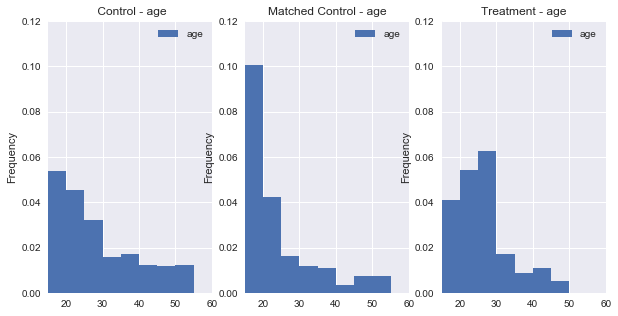

In [304]:
control_matched_age = control_matched[['age']]
treat_age= treat[['age']]


bin_values_age = np.arange(start=15, stop=60, step=5) # age ranges from 16 to 55

fig, axes = plt.subplots(1, 3, figsize=(10,5))
control_age.plot.hist(ax=axes[0], xlim = (15,60), ylim = (0,0.12), normed=True , title=' Control - age', bins=bin_values_age)
control_matched_age.plot.hist(ax=axes[1], xlim = (15,60), ylim = (0,0.12), normed=True , title='Matched Control - age', bins=bin_values_age)
treat_age.plot.hist(ax=axes[2], xlim = (15,60), ylim = (0,0.12), normed=True, title='Treatment - age', bins=bin_values_age)

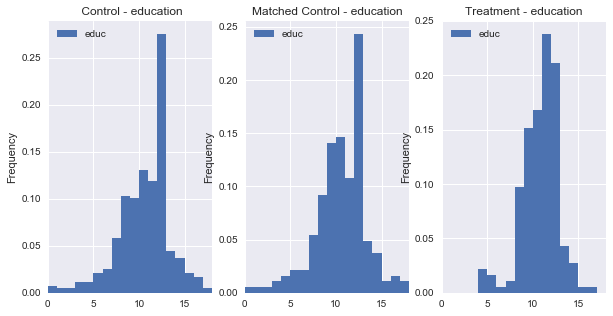

In [305]:
control_matched_educ = control_matched[['educ']]
treat_educ= treat[['educ']]

bin_values_educ = np.arange(start=0, stop=20, step=1) # education ranges from 0 to 18

fig, axes = plt.subplots(1, 3, figsize=(10,5))
control_educ.plot.hist(ax=axes[0], xlim = (0,18), normed=True , title=' Control - education', bins=bin_values_educ)
control_matched_educ.plot.hist(ax=axes[1], xlim = (0,18), normed=True , title='Matched Control - education', bins=bin_values_educ)
treat_educ.plot.hist(ax=axes[2], xlim = (0,18), normed=True, title='Treatment - education', bins=bin_values_educ)

#### Analysis of our matching

We can see that portion of married people has been balanced by the sampling.

For the ethnic decomposition the portion of black people has more than doubled in the matched sample of the control group, however it is still significantly different fron the treatment group. This is an issue that needs to be addressed in some further balancing in step 5.

Changes for nodegree and education are insignificant.

For age we observe that we have almost double the first bin (15-20) while (25-30) has been halved. Both bins perform worse than before. Hence the samples has unbalanced the distribution more.

#### 5. Balancing the groups further

Based on your comparison of feature-value distributions from part 4, are you fully satisfied with your matching?
Would you say your dataset is sufficiently balanced?
If not, in what ways could the "balanced" dataset you have obtained still not allow you to draw valid conclusions?

Improve your matching by explicitly making sure that you match only subjects that have the same value for the problematic feature.
Argue with numbers and plots that the two groups (treated and control) are now better balanced than after part 4.

#### 6. A less naive analysis

Compare the outcomes (`re78`) between treated and control subjects, as you've done in part 1, but now only for the matched dataset you've obtained from part 5.
What do you conclude about the effectiveness of the job training program?

## Question 2: Applied ML

We are going to build a classifier of news to directly assign them to 20 news categories. Note that the pipeline that you will build in this exercise could be of great help during your project if you plan to work with text



1. Load the 20newsgroup dataset. It is, again, a classic dataset that can directly be loaded using sklearn ([link](http://scikit-learn.org/stable/datasets/twenty_newsgroups.html)).  
[TF-IDF](https://en.wikipedia.org/wiki/Tf%E2%80%93idf), short for term frequency inverse document frequency, is of great help when if comes to compute textual features. Indeed, it gives more importance to terms that are more specific to the considered articles (TF) but reduces the importance of terms that are very frequent in the entire corpus (IDF). Compute TF-IDF features for every article using [TfidfVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html). Then, split your dataset into a training, a testing and a validation set (10% for validation and 10% for testing). Each observation should be paired with its corresponding label (the article category).


In [240]:
from sklearn.datasets import fetch_20newsgroups
# Get the news data set
newsgroups_20 = fetch_20newsgroups(subset = 'all', shuffle=True)
#Creat a dataframe
newsgroups_20_dataframe = pd.DataFrame({'Text': newsgroups_20.data,'Categories':    newsgroups_20.target})
newsgroups_20_dataframe.head()

,Categories,Text
0,10,From: Mamatha Devineni Ratnam <mr47+@andrew.cm...
1,3,From: mblawson@midway.ecn.uoknor.edu (Matthew ...
2,17,From: hilmi-er@dsv.su.se (Hilmi Eren)\nSubject...
3,3,From: guyd@austin.ibm.com (Guy Dawson)\nSubjec...
4,4,From: Alexander Samuel McDiarmid <am2o+@andrew...


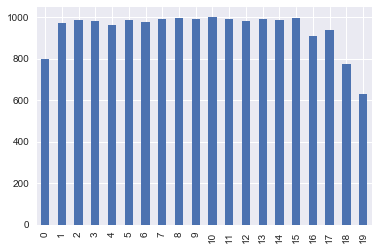

In [241]:
values = newsgroups_20_dataframe.Categories.value_counts()
values = values.sort_index()
# Plot the number of articles in each categorie
values.plot.bar()
plt.show()

The number of articles is equaly distributed except for a few, but the diffrens is not very high. Therefore can we keep the data set as it is.

In [242]:
from sklearn.feature_extraction.text import TfidfVectorizer
# Creat a Tf-idf vectiruzer
tf_idf = TfidfVectorizer()
tf_idf_results = tf_idf.fit_transform(newsgroups_20.data)
tf_idf_results

<18846x173762 sparse matrix of type '<class 'numpy.float64'>'
	with 2952534 stored elements in Compressed Sparse Row format>

In [243]:
# Taken from: http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html
from sklearn.model_selection import train_test_split
X = tf_idf_results
y = newsgroups_20_dataframe.Categories
# Creat a train set, a validation set and a test set
X_training, X_test_valid, y_training, y_test_valid = train_test_split(X, y, test_size=0.2, random_state=42)

X_valid, X_test, y_valid, y_test = train_test_split(X_test_valid, y_test_valid, test_size=0.5, random_state=42)



## Part 2
Train a random forest on your training set. Try to fine-tune the parameters of your predictor on your validation set using a simple grid search on the number of estimator "n_estimators" and the max depth of the trees "max_depth". Then, display a confusion matrix of your classification pipeline. Lastly, once you assessed your model, inspect the `feature_importances_` attribute of your random forest and discuss the obtained results.

Now we will use the random forest on our training set. In order to determine how many trees and how deep each tree should be we use Grid Search. Sklearn have a library called GridSearchCV that test diffrent parameters for number of trees and depth. We have choosed a interval from 10 to 230 for number of trees and values from 100 to 300 for the depth. We choosed these intervals since accuarcy score goes up a lot(25 %) from 10 forest to around 100 forest and then the accuarcy is almost the same for more than 100 forest. It also takes a lot of time to run the code which is also a reason wy we chosed this interval.

In [244]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
randomforest = RandomForestClassifier()



In [155]:
from sklearn.model_selection import GridSearchCV
# Creat a random forest varible
randomforest = RandomForestClassifier()
#Values for test of depth and number of forest
param_grid = {"max_depth": range(100,300,50),
             "n_estimators": range(10,230,30)}

# Performing the GridSearch, GridSearchCV implements a “fit” and a “score” method. It test the diffrent values for 
# depth and number of forest by calculating the accuracyscore which it get for comparing the estimate against the
# true values, for this case the values are the diffrent categories. We have commented out the code for the grid search
# because of the long runing time.

#gridsearch = GridSearchCV(randomforest, param_grid, n_jobs=-1,verbose = 10) 
#gridsearch = gridsearch.fit(X_train, y_train)

# Get the best score and respective paramters.
#gridsearch.best_score_
#gridsearch.best_params_

Fitting 3 folds for each of 32 candidates, totalling 96 fits
[CV] max_depth=100, n_estimators=10 ..................................
[CV] max_depth=100, n_estimators=10 ..................................
[CV] max_depth=100, n_estimators=10 ..................................
[CV] max_depth=100, n_estimators=40 ..................................
[CV] ... max_depth=100, n_estimators=10, score=0.654513, total=   9.0s
[CV] max_depth=100, n_estimators=40 ..................................
[CV] ... max_depth=100, n_estimators=10, score=0.645399, total=   9.4s
[CV] max_depth=100, n_estimators=40 ..................................
[CV] ... max_depth=100, n_estimators=10, score=0.623955, total=  10.1s
[CV] max_depth=100, n_estimators=70 ..................................
[CV] ... max_depth=100, n_estimators=40, score=0.776983, total=  38.4s
[CV] max_depth=100, n_estimators=70 ..................................
[CV] ... max_depth=100, n_estimators=40, score=0.797171, total=  38.2s
[CV] max_depth=1

[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   49.2s


[CV] ... max_depth=100, n_estimators=40, score=0.766614, total=  40.9s
[CV] max_depth=100, n_estimators=100 .................................
[CV] ... max_depth=100, n_estimators=70, score=0.807792, total= 1.2min
[CV] max_depth=100, n_estimators=100 .................................
[CV] ... max_depth=100, n_estimators=70, score=0.804019, total= 1.2min
[CV] max_depth=100, n_estimators=100 .................................
[CV] ... max_depth=100, n_estimators=70, score=0.818290, total= 1.1min
[CV] max_depth=100, n_estimators=130 .................................
[CV] .. max_depth=100, n_estimators=100, score=0.822103, total= 1.6min
[CV] max_depth=100, n_estimators=130 .................................


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  2.5min


[CV] .. max_depth=100, n_estimators=100, score=0.813370, total= 1.7min
[CV] max_depth=100, n_estimators=130 .................................
[CV] .. max_depth=100, n_estimators=100, score=0.828452, total= 1.6min
[CV] max_depth=100, n_estimators=160 .................................
[CV] .. max_depth=100, n_estimators=130, score=0.826078, total= 2.1min
[CV] max_depth=100, n_estimators=160 .................................
[CV] .. max_depth=100, n_estimators=130, score=0.824115, total= 2.2min
[CV] max_depth=100, n_estimators=160 .................................
[CV] .. max_depth=100, n_estimators=130, score=0.836422, total= 2.1min
[CV] max_depth=100, n_estimators=190 .................................
[CV] .. max_depth=100, n_estimators=160, score=0.832638, total= 2.8min
[CV] max_depth=100, n_estimators=190 .................................
[CV] .. max_depth=100, n_estimators=160, score=0.829686, total= 2.9min
[CV] max_depth=100, n_estimators=190 .................................


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  7.1min


[CV] .. max_depth=100, n_estimators=160, score=0.846981, total= 2.7min
[CV] max_depth=100, n_estimators=220 .................................
[CV] .. max_depth=100, n_estimators=190, score=0.837011, total= 3.3min
[CV] max_depth=100, n_estimators=220 .................................
[CV] .. max_depth=100, n_estimators=190, score=0.829686, total= 3.2min
[CV] max_depth=100, n_estimators=220 .................................
[CV] .. max_depth=100, n_estimators=190, score=0.845587, total= 3.0min
[CV] max_depth=150, n_estimators=10 ..................................
[CV] ... max_depth=150, n_estimators=10, score=0.636852, total=  12.0s
[CV] max_depth=150, n_estimators=10 ..................................
[CV] ... max_depth=150, n_estimators=10, score=0.603661, total=  13.6s
[CV] max_depth=150, n_estimators=10 ..................................
[CV] ... max_depth=150, n_estimators=10, score=0.641761, total=  13.5s
[CV] max_depth=150, n_estimators=40 ..................................


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed: 10.9min


[CV] .. max_depth=100, n_estimators=220, score=0.839595, total= 3.7min
[CV] max_depth=150, n_estimators=40 ..................................
[CV] ... max_depth=150, n_estimators=40, score=0.778573, total=  54.8s
[CV] max_depth=150, n_estimators=40 ..................................
[CV] ... max_depth=150, n_estimators=40, score=0.770792, total=  54.4s
[CV] max_depth=150, n_estimators=70 ..................................
[CV] .. max_depth=100, n_estimators=220, score=0.828293, total= 3.8min
[CV] max_depth=150, n_estimators=70 ..................................
[CV] ... max_depth=150, n_estimators=40, score=0.789201, total=  51.3s
[CV] max_depth=150, n_estimators=70 ..................................
[CV] .. max_depth=100, n_estimators=220, score=0.848575, total= 3.7min
[CV] max_depth=150, n_estimators=100 .................................
[CV] ... max_depth=150, n_estimators=70, score=0.818525, total= 1.5min
[CV] max_depth=150, n_estimators=100 .................................
[CV] .

[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed: 14.1min


[CV] .. max_depth=150, n_estimators=100, score=0.826476, total= 1.9min
[CV] max_depth=150, n_estimators=130 .................................
[CV] .. max_depth=150, n_estimators=100, score=0.818544, total= 2.0min
[CV] max_depth=150, n_estimators=130 .................................
[CV] .. max_depth=150, n_estimators=100, score=0.821279, total= 1.9min
[CV] max_depth=150, n_estimators=160 .................................
[CV] .. max_depth=150, n_estimators=130, score=0.831246, total= 2.5min
[CV] max_depth=150, n_estimators=160 .................................
[CV] .. max_depth=150, n_estimators=130, score=0.823518, total= 2.6min
[CV] max_depth=150, n_estimators=160 .................................
[CV] .. max_depth=150, n_estimators=130, score=0.836422, total= 2.5min
[CV] max_depth=150, n_estimators=190 .................................
[CV] .. max_depth=150, n_estimators=160, score=0.840191, total= 3.3min
[CV] max_depth=150, n_estimators=190 .................................
[CV] .

[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 21.4min


[CV] .. max_depth=150, n_estimators=190, score=0.842576, total= 3.9min
[CV] max_depth=150, n_estimators=220 .................................
[CV] .. max_depth=150, n_estimators=190, score=0.826701, total= 4.1min
[CV] max_depth=150, n_estimators=220 .................................
[CV] .. max_depth=150, n_estimators=190, score=0.848575, total= 3.9min
[CV] max_depth=200, n_estimators=10 ..................................
[CV] ... max_depth=200, n_estimators=10, score=0.612006, total=  12.8s
[CV] max_depth=200, n_estimators=10 ..................................
[CV] ... max_depth=200, n_estimators=10, score=0.607043, total=  15.2s
[CV] max_depth=200, n_estimators=10 ..................................
[CV] ... max_depth=200, n_estimators=10, score=0.619845, total=  14.4s
[CV] max_depth=200, n_estimators=40 ..................................
[CV] ... max_depth=200, n_estimators=40, score=0.789306, total= 1.0min
[CV] max_depth=200, n_estimators=40 ..................................
[CV] .

[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed: 27.6min


[CV] .. max_depth=150, n_estimators=220, score=0.843993, total= 4.8min
[CV] max_depth=200, n_estimators=100 .................................
[CV] ... max_depth=200, n_estimators=70, score=0.813158, total= 1.7min
[CV] max_depth=200, n_estimators=100 .................................
[CV] ... max_depth=200, n_estimators=70, score=0.804417, total= 1.8min
[CV] max_depth=200, n_estimators=100 .................................
[CV] ... max_depth=200, n_estimators=70, score=0.821478, total= 1.7min
[CV] max_depth=200, n_estimators=130 .................................
[CV] .. max_depth=200, n_estimators=100, score=0.826873, total= 2.4min
[CV] max_depth=200, n_estimators=130 .................................
[CV] .. max_depth=200, n_estimators=100, score=0.816952, total= 2.4min
[CV] max_depth=200, n_estimators=130 .................................
[CV] .. max_depth=200, n_estimators=100, score=0.831042, total= 2.2min
[CV] max_depth=200, n_estimators=160 .................................
[CV] .

[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed: 35.4min


[CV] .. max_depth=200, n_estimators=160, score=0.825507, total= 4.0min
[CV] max_depth=200, n_estimators=190 .................................
[CV] .. max_depth=200, n_estimators=160, score=0.845388, total= 3.8min
[CV] max_depth=200, n_estimators=220 .................................
[CV] .. max_depth=200, n_estimators=190, score=0.836812, total= 4.6min
[CV] max_depth=200, n_estimators=220 .................................
[CV] .. max_depth=200, n_estimators=190, score=0.831874, total= 5.0min
[CV] max_depth=200, n_estimators=220 .................................
[CV] .. max_depth=200, n_estimators=190, score=0.846782, total= 4.7min
[CV] max_depth=250, n_estimators=10 ..................................
[CV] ... max_depth=250, n_estimators=10, score=0.642616, total=  13.8s
[CV] max_depth=250, n_estimators=10 ..................................
[CV] ... max_depth=250, n_estimators=10, score=0.614604, total=  14.3s
[CV] max_depth=250, n_estimators=10 ..................................
[CV] .

[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed: 44.8min


[CV] .. max_depth=200, n_estimators=220, score=0.845985, total= 5.0min
[CV] max_depth=250, n_estimators=100 .................................
[CV] ... max_depth=250, n_estimators=70, score=0.809978, total= 1.6min
[CV] max_depth=250, n_estimators=100 .................................
[CV] ... max_depth=250, n_estimators=70, score=0.797652, total= 1.7min
[CV] max_depth=250, n_estimators=100 .................................
[CV] ... max_depth=250, n_estimators=70, score=0.815302, total= 1.6min
[CV] max_depth=250, n_estimators=130 .................................
[CV] .. max_depth=250, n_estimators=100, score=0.827072, total= 2.4min
[CV] max_depth=250, n_estimators=130 .................................
[CV] .. max_depth=250, n_estimators=100, score=0.811779, total= 2.5min
[CV] max_depth=250, n_estimators=130 .................................
[CV] .. max_depth=250, n_estimators=100, score=0.829847, total= 2.5min
[CV] max_depth=250, n_estimators=160 .................................
[CV] .

[Parallel(n_jobs=-1)]: Done  96 out of  96 | elapsed: 63.2min finished


KeyboardInterrupt: 

In [245]:
# We got the best accuracy (0.0848575) for max_depth=100, n_estimators=220, score=0.848575 and 
#max_depth=150, n_estimators=190, score=0.848575
best_n_trees = 190
best_depth = 150

Now we plot the confusion matrix. 

In [172]:

#This plot the confusion Matrix
# Taken from http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

NameError: name 'class_names' is not defined

In [246]:
#Creat a random forest with the best values
randomforest_best= RandomForestClassifier(max_depth=best_depth, n_estimators=best_n_trees, n_jobs=-1)
#Train the model
randomforest_best.fit(X_training, y_training)
# Do a test of the model on the test set
y_pred = randomforest_best.predict(X_test)

Normalized confusion matrix


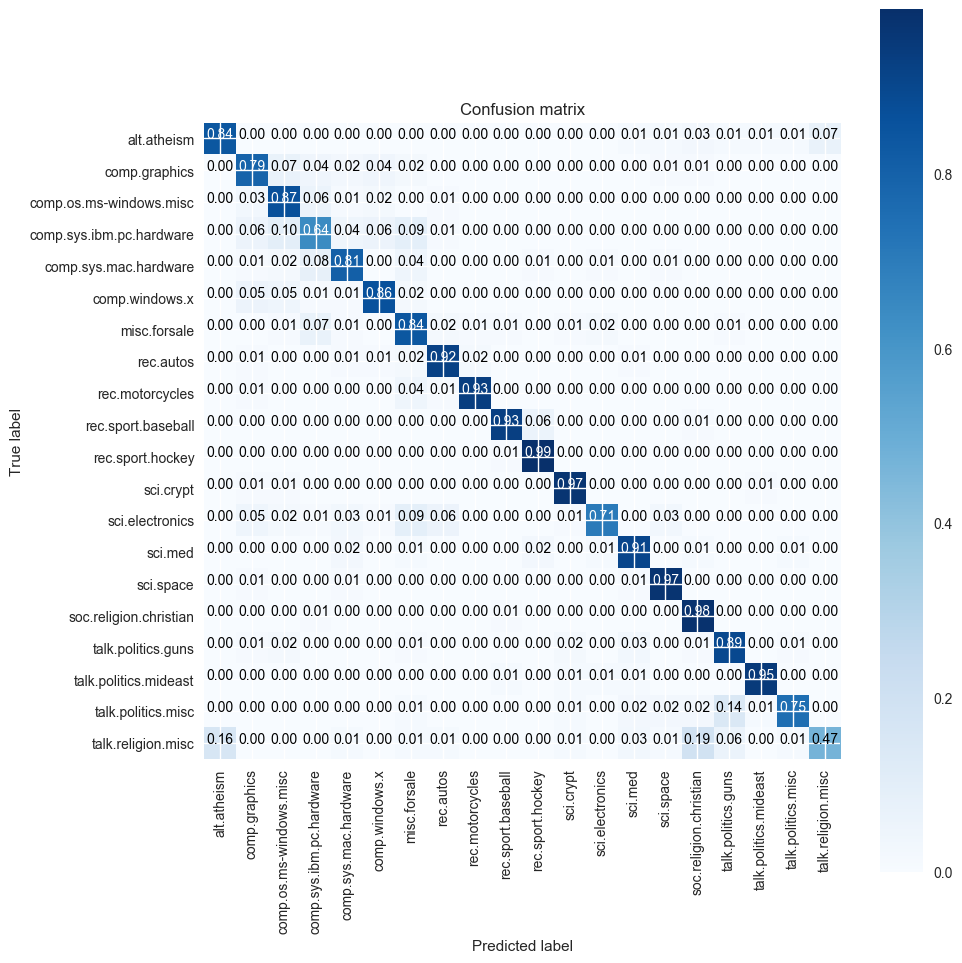

In [247]:

#Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10,10),dpi=100)
# Plot the confusion Matrix
plot_confusion_matrix(cm,classes=newsgroups_20.target_names,normalize = True)
plt.show()

Looking a the confusion matrix tells ous that the prediction is very good for most categories except for talk.religion, sci.electronics and talk.politics. Why these prediction are bad, especially talk.religion, is probobly because they are familiar to other categories like religion will be metioned in christian, politics etc. 

# Feature Importance


In [264]:
feature = pd.DataFrame(randomforest_best.feature_importances_, columns=['Importance']) 

feature['Value'] = tf_idf.get_feature_names() 

feature = feature.sort_values('Importance', ascending=False)
feature.head()

,Importance,Value
0,0.013103,windows
1,0.013054,sale
2,0.012778,dod
5,0.011541,car
4,0.009783,bike


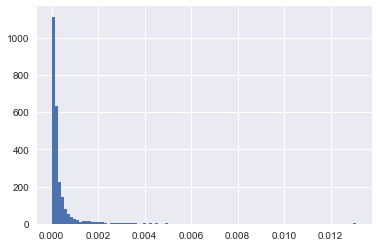

In [272]:
plt.hist(feature.Importance, bins=100)
plt.show()

The plot show that there are only a few features that have a high importance. So by choosing these features and only train on them would probably achive the same results but with much less calculation power. Let's calculate the accuracy for the top 2500 features.

In [268]:
words = feature.Value.head(2500)
words.head()

0    windows
1       sale
2        dod
5        car
4       bike
Name: Value, dtype: object

In [257]:
# Do a Tf-idf veactorizer with the 2500 most importand features
tf_idf = TfidfVectorizer(vocabulary=words)
tf_idf_results = tf_idf.fit_transform(newsgroups_20.data)

X = tf_idf_results
y = newsgroups_20_dataframe.Categories
# Creat a train set, a validation set and a test set
X_training, X_test, y_training, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

#Creat a random forest with the best values
randomforest_best= RandomForestClassifier(max_depth=best_depth, n_estimators=best_n_trees, n_jobs=-1)
#Train the model
randomforest_best.fit(X_training, y_training)
# Do a test of the model on the test set
y_pred = randomforest_best.predict(X_test)

print(accuracy_score(y_pred, y_test))

0.806896551724


The accuracy for calculation with the top 2500 features is 0.8068965 compared to 0.0848575, which is pretty good.  By taking the only the first 2500 features we get a similar reasults but the calculation time is less. 